In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, torch, pickle, csv
import numpy as np
import scipy as sp
sys.path.append('/lfs/1/danfu/metal')
sys.path.append('/lfs/1/danfu/sequential_ws')
from metal.metrics import metric_score
from torch.nn.functional import normalize
from DP.label_model import *
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda:0')

# Load Data

In [4]:
L_train_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_train_100_windows_downsampled.npz'
L_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_val_windows_downsampled.npz'
Y_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_val_windows_downsampled.npy'
L_test_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_test_windows_downsampled.npz'
Y_test_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_test_windows_downsampled.npy'

stride = 1
L_train_raw = sp.sparse.load_npz(L_train_path).todense()[::stride]
L_dev_raw = sp.sparse.load_npz(L_dev_path).todense()
Y_dev_raw = np.load(Y_dev_path)
L_test_raw = sp.sparse.load_npz(L_test_path).todense()
Y_test_raw = np.load(Y_test_path)

T = 5

L_train = torch.FloatTensor(L_train_raw[:L_train_raw.shape[0] - (L_train_raw.shape[0] % T)]).to(device)
L_dev = torch.FloatTensor(L_dev_raw[:L_dev_raw.shape[0] - (L_dev_raw.shape[0] % T)]).to(device)
Y_dev = torch.FloatTensor(Y_dev_raw[:Y_dev_raw.shape[0] - (Y_dev_raw.shape[0] % T)]).to(device)
L_test = torch.FloatTensor(L_test_raw[:L_test_raw.shape[0] - (L_test_raw.shape[0] % T)]).to(device)
Y_test = torch.FloatTensor(Y_test_raw[:Y_test_raw.shape[0] - (Y_test_raw.shape[0] % T)]).to(device)
m_per_task = L_train.size(1)
n_frames_train = L_train.size(0)
n_patients_train = n_frames_train//T
n_frames_dev = L_dev.size(0)
n_patients_dev = n_frames_dev//T
n_frames_test = L_test.size(0)
n_patients_test = n_frames_test//T

# MRI_data_naive = {'Li_train': (L_train.unsqueeze(2) == torch.FloatTensor([-1,1,0]).to(device).unsqueeze(0).unsqueeze(0)).argmax(2),
#                   'Li_dev': (L_dev.unsqueeze(2) == torch.FloatTensor([-1,1,0]).to(device).unsqueeze(0).unsqueeze(0)).argmax(2),
#                   'R_dev': (Y_dev.unsqueeze(1) == torch.FloatTensor([-1,1]).to(device).unsqueeze(0)).argmax(1),
#                   'm':m_per_task, 'T':1,
#                  }

# don't need to transform the raw data
MRI_data_naive = {'Li_train': L_train.long().to(device),
                  'Li_dev': L_dev.long().to(device),
                  'R_dev': Y_dev.long().to(device),
                  'Li_test': L_test.long().to(device),
                  'R_test': Y_test.long().to(device),
                  'm':m_per_task, 'T':1,
                 }
MRI_data_naive['class_balance'] = normalize((MRI_data_naive['R_dev'].unsqueeze(1)==torch.arange(2, device=device).unsqueeze(0)).sum(0).float(), 
                                            dim=0, p=1)
MRI_data_temporal = {'Li_train': MRI_data_naive['Li_train'].view(n_patients_train, (m_per_task*T)),
                     'Li_dev': MRI_data_naive['Li_dev'].view(n_patients_dev, (m_per_task*T)),
                     'R_dev': MRI_data_naive['R_dev']*(2**T-1),
                     'Li_test': MRI_data_naive['Li_test'].view(n_patients_test, (m_per_task*T)),
                     'R_test': MRI_data_naive['R_test']*(2**T-1),
                     'm': m_per_task * T, 'T': T,
                    } 
MRI_data_temporal['class_balance'] = normalize((MRI_data_temporal['R_dev'].unsqueeze(1)==torch.arange(2**T, device=device).unsqueeze(0)).sum(0).float(), 
                                                dim=0, p=1)

# Naive Model

In [12]:
MRI_data_naive['class_balance']

tensor([0., 1.], device='cuda:0')

In [5]:
naive_model = DPLabelModel(m=m_per_task, 
                           T=1,
                           edges=[],
                           coverage_sets=[[0,]]*m_per_task,
                           mu_sharing=[[i,] for i in range(m_per_task)],
                           phi_sharing=[],
                           device=device,
                           # class_balance=MRI_data_naive['class_balance'], 
                           seed=0)
optimize(naive_model, L_hat=MRI_data_naive['Li_train'], num_iter=3000, lr=4.087885261759692e-05,
         momentum=0.9, clamp=True, seed=2)

iteration=0 loss=50.6702766418457
iteration=300 loss=8.80715274810791
iteration=600 loss=3.66485595703125
iteration=900 loss=1.8281009197235107
iteration=1200 loss=0.9653668999671936
iteration=1500 loss=0.6120548844337463
iteration=1800 loss=0.4767417907714844
iteration=2100 loss=0.40450260043144226
iteration=2400 loss=0.3607012629508972
iteration=2700 loss=0.3310929536819458
iteration=2999 loss=0.30959445238113403


In [6]:
R_pred = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.125
F1: 0.389
Recall: 0.712
Precision: 0.268


In [8]:
# Flipping params
print("Flipping Parameters")
naive_model.flip_params()
R_pred_flipped = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred_flipped.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Flipping Parameters
Accuracy: 0.051
F1: 0.143
Recall: 0.288
Precision: 0.095


In [ ]:
naive_model = DPLabelModel(m=m_per_task, 
                           T=1,
                           edges=[],
                           coverage_sets=[[0,]]*m_per_task,
                           mu_sharing=[[i,] for i in range(m_per_task)],
                           phi_sharing=[],
                           device=device,
                           class_balance=torch.tensor([.4, .6]).to(device), 
                           seed=0)
optimize(naive_model, L_hat=MRI_data_naive['Li_train'], num_iter=5000, lr=4.087885261759692e-04,
         momentum=0.9, clamp=False, seed=10)

In [41]:
R_pred = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.171
F1: 0.488
Recall: 0.971
Precision: 0.326


In [44]:
# Flipping params
print("Flipping Parameters")
naive_model.flip_params()
R_pred_flipped = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred_flipped.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Flipping Parameters
Accuracy: 0.069
F1: 0.185
Recall: 0.389
Precision: 0.121


In [64]:
naive_model = DPLabelModel(m=m_per_task, 
                           T=1,
                           edges=[],
                           coverage_sets=[[0,]]*m_per_task,
                           mu_sharing=[[i,] for i in range(m_per_task)],
                           phi_sharing=[],
                           device=device,
                           class_balance=torch.tensor([.3, .7]).to(device), 
                           seed=0)
optimize(naive_model, L_hat=MRI_data_naive['Li_train'], num_iter=1000, lr=2.087885261759692e-02,
         momentum=0., clamp=False, seed=11)

iteration=0 loss=53.89699172973633
iteration=100 loss=0.3030668795108795
iteration=200 loss=0.23939409852027893
iteration=300 loss=0.22569435834884644
iteration=400 loss=0.22112223505973816
iteration=500 loss=0.21906107664108276
iteration=600 loss=0.2178979068994522
iteration=700 loss=0.2171371728181839
iteration=800 loss=0.21659354865550995
iteration=900 loss=0.21618370711803436
iteration=999 loss=0.21586711704730988


In [65]:
R_pred = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.172
F1: 0.489
Recall: 0.975
Precision: 0.326


In [66]:
# Flipping params
print("Flipping Parameters")
naive_model.flip_params()
R_pred_flipped = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred_flipped.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Flipping Parameters
Accuracy: 0.137
F1: 0.245
Recall: 0.777
Precision: 0.145


In [81]:
naive_model = DPLabelModel(m=m_per_task, 
                           T=1,
                           edges=[],
                           coverage_sets=[[0,]]*m_per_task,
                           mu_sharing=[[i,] for i in range(m_per_task)],
                           phi_sharing=[],
                           device=device,
                           class_balance=torch.tensor([-.1, 1.1]).to(device), 
                           seed=0)
optimize(naive_model, L_hat=MRI_data_naive['Li_train'], num_iter=5000, lr=1.087885261759692e-02,
         momentum=0.3, clamp=False, seed=11)

iteration=0 loss=66.03443145751953
iteration=500 loss=2.6357004642486572
iteration=1000 loss=0.3299635946750641
iteration=1500 loss=0.29519757628440857
iteration=2000 loss=0.2911560535430908
iteration=2500 loss=0.28930333256721497
iteration=3000 loss=0.2881740927696228
iteration=3500 loss=0.28736594319343567
iteration=4000 loss=0.28671225905418396
iteration=4500 loss=0.2861360013484955
iteration=4999 loss=0.2856000065803528


In [82]:
R_pred = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")
    # Flipping params
print("Flipping Parameters")
naive_model.flip_params()
R_pred_flipped = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred_flipped.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.154
F1: 0.452
Recall: 0.874
Precision: 0.304
Flipping Parameters
Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000


In [98]:
naive_model = DPLabelModel(m=m_per_task, 
                           T=1,
                           edges=[],
                           coverage_sets=[[0,]]*m_per_task,
                           mu_sharing=[[i,] for i in range(m_per_task)],
                           phi_sharing=[],
                           device=device,
                           class_balance=torch.tensor([.4, .6]).to(device), 
                           seed=0)
optimize(naive_model, L_hat=MRI_data_naive['Li_train'][::4000], num_iter=2000, lr=1.087885261759692e-03,
         momentum=.9, clamp=False, seed=11)

iteration=0 loss=52.20237731933594
iteration=200 loss=0.23215782642364502
iteration=400 loss=0.19091296195983887
iteration=600 loss=0.183028444647789
iteration=800 loss=0.18011479079723358
iteration=1000 loss=0.17864780128002167
iteration=1200 loss=0.17776866257190704
iteration=1400 loss=0.17718084156513214
iteration=1600 loss=0.17675688862800598
iteration=1800 loss=0.1764335036277771
iteration=1999 loss=0.176177516579628


In [94]:
R_pred = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")
    # Flipping params
print("Flipping Parameters")
naive_model.flip_params()
R_pred_flipped = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred_flipped.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.171
F1: 0.488
Recall: 0.971
Precision: 0.326
Flipping Parameters
Accuracy: 0.069
F1: 0.185
Recall: 0.389
Precision: 0.121


# Timeseries model

In [5]:
valid_target = Y_dev.long()
T = 5

feasible_y = np.array([[-1, -1, -1, -1, -1],
        [-1,  1, -1, -1, -1],
        [ 1, -1, -1, -1, -1],
        [ 1,  1, -1, -1, -1],
        [-1, -1,  1, -1, -1],
        [-1,  1,  1, -1, -1],
        [ 1, -1,  1, -1, -1],
        [ 1,  1,  1, -1, -1],
        [-1, -1, -1,  1, -1],
        [-1,  1, -1,  1, -1],
        [ 1, -1, -1,  1, -1],
        [ 1,  1, -1,  1, -1],
        [-1, -1,  1,  1, -1],
        [-1,  1,  1,  1, -1],
        [ 1, -1,  1,  1, -1],
        [ 1,  1,  1,  1, -1],
        [-1, -1, -1, -1,  1],
        [-1,  1, -1, -1,  1],
        [ 1, -1, -1, -1,  1],
        [ 1,  1, -1, -1,  1],
        [-1, -1,  1, -1,  1],
        [-1,  1,  1, -1,  1],
        [ 1, -1,  1, -1,  1],
        [ 1,  1,  1, -1,  1],
        [-1, -1, -1,  1,  1],
        [-1,  1, -1,  1,  1],
        [ 1, -1, -1,  1,  1],
        [ 1,  1, -1,  1,  1],
        [-1, -1,  1,  1,  1],
        [-1,  1,  1,  1,  1],
        [ 1, -1,  1,  1,  1],
        [ 1,  1,  1,  1,  1]])

feasible_y[feasible_y==-1] = 0
feasible_y = feasible_y.tolist()
possibilities = list(map(lambda l : ''.join(map(str,l)), feasible_y))

class_balance = np.empty(2 ** T)
#compute class balance from dev set and use laplace smoothing

valid_target_copy = np.copy(valid_target)
valid_target_copy[valid_target_copy == 2] = 0

assert len(valid_target_copy) % T == 0
num_windows = len(valid_target_copy) / T

freq = {}
for i in range(0, len(valid_target_copy), T):
    s = ''.join(map(str,valid_target_copy[i:i+T]))
    if s in freq:
        freq[s] += 1
    else:
        freq[s] = 1

for i in range(len(class_balance)):
    if possibilities[i] in freq and freq[possibilities[i]] > 5:
        class_balance[i] = (freq[possibilities[i]] + 1) / (num_windows + len(possibilities))
    else:
        class_balance[i] = 0.

In [40]:
%%time
best = None
for iterations in [1, 5,10, 25, 50, 100, 200]:
    for learning_rate in [1e-4, 1e-5, 1e-6, 1e-7]:
        print(iterations, learning_rate)
        max_seed = 10
        temporal_models = [None,]*max_seed
        for seed in range(max_seed):
            print(seed)
            markov_model = DPLabelModel(m=m_per_task*T, 
                                        T=T,
                                        edges=[(i,i+m_per_task) for i in range((T-1)*m_per_task)],
                                        coverage_sets=[[t,] for t in range(T) for _ in range(m_per_task)],
                                        mu_sharing=[[t*m_per_task+i for t in range(T)] for i in range(m_per_task)],
                                        phi_sharing=[[(t*m_per_task+i, (t+1)*m_per_task+i)
                                                      for t in range(T-1)] for i in range(m_per_task)],
                                        device=device,
                                        class_balance=torch.tensor(class_balance).float().to(device),
                                        seed=seed)
            optimize(markov_model, L_hat=MRI_data_temporal['Li_train'], num_iter=iterations,
                     lr=1e-5, momentum=0.8, clamp=True, 
                     verbose=iterations >= 10, seed=seed)
            temporal_models[seed] = markov_model

        for seed, model in enumerate(temporal_models):
            Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
            R_pred_frame_label = model.predict_element_proba(Li_dev.to(device)) #predict per element

            scores = [iterations, seed, model]
            for metric in ['accuracy', 'f1', 'recall', 'precision']:
                score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
                print(f"{metric.capitalize()}: {score:.3f}")

                scores.append(score)
                
            model.flip_params()
            R_pred_frame_label = model.predict_element_proba(Li_dev.to(device)) #predict per element

            for metric in ['accuracy', 'f1', 'recall', 'precision']:
                score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
                print(f"{metric.capitalize()}: {score:.3f}")

                scores.append(score)
            
            model.flip_params()

            if best == None or scores[4] > max(best[4], best[8]) or scores[8] > max(best[4], best[8]):
                best = scores
            print()

print(best)

1 0.0001
0
1
2
3
4
5
6
7
8
9
Accuracy: 0.036
F1: 0.381
Recall: 0.249
Precision: 0.810
Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000

Accuracy: 0.019
F1: 0.200
Recall: 0.132
Precision: 0.414
Accuracy: 0.032
F1: 0.203
Recall: 0.220
Precision: 0.189

Accuracy: 0.050
F1: 0.316
Recall: 0.348
Precision: 0.290
Accuracy: 0.008
F1: 0.080
Recall: 0.055
Precision: 0.150

Accuracy: 0.062
F1: 0.552
Recall: 0.429
Precision: 0.775
Accuracy: 0.010
F1: 0.043
Recall: 0.066
Precision: 0.032

Accuracy: 0.024
F1: 0.239
Recall: 0.168
Precision: 0.411
Accuracy: 0.002
F1: 0.022
Recall: 0.011
Precision: 0.600

Accuracy: 0.003
F1: 0.017
Recall: 0.018
Precision: 0.017
Accuracy: 0.097
F1: 0.751
Recall: 0.667
Precision: 0.858

Accuracy: 0.007
F1: 0.043
Recall: 0.048
Precision: 0.039
Accuracy: 0.107
F1: 0.736
Recall: 0.740
Precision: 0.732

Accuracy: 0.005
F1: 0.023
Recall: 0.037
Precision: 0.017
Accuracy: 0.038
F1: 0.406
Recall: 0.260
Precision: 0.922

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 


5 1e-07
0
1
2
3
4
5
6
7
8
9
Accuracy: 0.055
F1: 0.505
Recall: 0.381
Precision: 0.748
Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000

Accuracy: 0.086
F1: 0.707
Recall: 0.597
Precision: 0.867
Accuracy: 0.012
F1: 0.074
Recall: 0.084
Precision: 0.066

Accuracy: 0.055
F1: 0.331
Recall: 0.377
Precision: 0.295
Accuracy: 0.010
F1: 0.086
Recall: 0.070
Precision: 0.111

Accuracy: 0.078
F1: 0.646
Recall: 0.538
Precision: 0.808
Accuracy: 0.008
F1: 0.035
Recall: 0.055
Precision: 0.026

Accuracy: 0.057
F1: 0.536
Recall: 0.396
Precision: 0.831
Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000

Accuracy: 0.010
F1: 0.105
Recall: 0.066
Precision: 0.261
Accuracy: 0.048
F1: 0.449
Recall: 0.330
Precision: 0.703

Accuracy: 0.011
F1: 0.098
Recall: 0.077
Precision: 0.134
Accuracy: 0.096
F1: 0.559
Recall: 0.663
Precision: 0.483

Accuracy: 0.083
F1: 0.447
Recall: 0.571
Precision: 0.367
Accuracy: 0.001
F1: 0.013
Recall: 0.007
Precision: 0.074

Accuracy: 0.002
F1: 0.020
Recall: 0.015
Precision: 

iteration=9 loss=2597.989501953125
iteration=9 loss=2597.989501953125
6
iteration=0 loss=9038.86328125
iteration=1 loss=6149.13671875
iteration=2 loss=4107.5908203125
iteration=3 loss=3203.435546875
iteration=4 loss=2905.21337890625
iteration=5 loss=2914.696044921875
iteration=6 loss=3050.10400390625
iteration=7 loss=3110.96044921875
iteration=8 loss=3030.776611328125
iteration=9 loss=2854.2998046875
iteration=9 loss=2854.2998046875
7
iteration=0 loss=11144.638671875
iteration=1 loss=6451.8125
iteration=2 loss=3951.136962890625
iteration=3 loss=3086.358642578125
iteration=4 loss=2908.28271484375
iteration=5 loss=3048.087890625
iteration=6 loss=3281.242919921875
iteration=7 loss=3359.569580078125
iteration=8 loss=3190.38134765625
iteration=9 loss=2907.2734375
iteration=9 loss=2907.2734375
8
iteration=0 loss=11542.0048828125
iteration=1 loss=7083.20703125
iteration=2 loss=4493.58544921875
iteration=3 loss=3472.33056640625
iteration=4 loss=3128.27880859375
iteration=5 loss=3096.9523925781

iteration=8 loss=2475.24365234375
iteration=9 loss=2350.2607421875
iteration=9 loss=2350.2607421875
2
iteration=0 loss=6387.94580078125
iteration=1 loss=5487.10498046875
iteration=2 loss=4454.2978515625
iteration=3 loss=3678.1845703125
iteration=4 loss=3190.572265625
iteration=5 loss=2928.121337890625
iteration=6 loss=2821.7470703125
iteration=7 loss=2798.736083984375
iteration=8 loss=2782.960205078125
iteration=9 loss=2716.3466796875
iteration=9 loss=2716.3466796875
3
iteration=0 loss=4468.0078125
iteration=1 loss=4093.1259765625
iteration=2 loss=3619.044189453125
iteration=3 loss=3228.59423828125
iteration=4 loss=2967.9345703125
iteration=5 loss=2817.573974609375
iteration=6 loss=2739.201904296875
iteration=7 loss=2691.9873046875
iteration=8 loss=2640.67041015625
iteration=9 loss=2563.614990234375
iteration=9 loss=2563.614990234375
4
iteration=0 loss=6314.5498046875
iteration=1 loss=5145.59619140625
iteration=2 loss=3987.45849609375
iteration=3 loss=3271.37890625
iteration=4 loss=292

iteration=4 loss=3128.27880859375
iteration=6 loss=3189.439453125
iteration=8 loss=3003.33984375
iteration=10 loss=2540.114501953125
iteration=12 loss=2111.530517578125
iteration=14 loss=1842.0155029296875
iteration=16 loss=1696.781982421875
iteration=18 loss=1602.4034423828125
iteration=20 loss=1523.418701171875
iteration=22 loss=1445.839111328125
iteration=24 loss=1357.8831787109375
iteration=24 loss=1357.8831787109375
9
iteration=0 loss=6166.609375
iteration=2 loss=3962.605224609375
iteration=4 loss=2794.06689453125
iteration=6 loss=2469.23876953125
iteration=8 loss=2403.12255859375
iteration=10 loss=2217.6494140625
iteration=12 loss=1883.8006591796875
iteration=14 loss=1589.754638671875
iteration=16 loss=1397.10205078125
iteration=18 loss=1269.0604248046875
iteration=20 loss=1172.8343505859375
iteration=22 loss=1100.8773193359375
iteration=24 loss=1059.69580078125
iteration=24 loss=1059.69580078125
Accuracy: 0.112
F1: 0.709
Recall: 0.773
Precision: 0.655
Accuracy: 0.001
F1: 0.013
R

iteration=4 loss=3159.949951171875
iteration=6 loss=2825.76708984375
iteration=8 loss=2709.9521484375
iteration=10 loss=2499.630859375
iteration=12 loss=2278.9375
iteration=14 loss=2053.9521484375
iteration=16 loss=1874.3697509765625
iteration=18 loss=1743.015380859375
iteration=20 loss=1643.98291015625
iteration=22 loss=1569.89306640625
iteration=24 loss=1514.773193359375
iteration=24 loss=1514.773193359375
1
iteration=0 loss=6498.72216796875
iteration=2 loss=3984.01513671875
iteration=4 loss=2772.7314453125
iteration=6 loss=2589.6875
iteration=8 loss=2475.24365234375
iteration=10 loss=2202.6171875
iteration=12 loss=1891.5181884765625
iteration=14 loss=1638.3114013671875
iteration=16 loss=1474.6983642578125
iteration=18 loss=1377.6141357421875
iteration=20 loss=1318.623046875
iteration=22 loss=1243.11865234375
iteration=24 loss=1164.747802734375
iteration=24 loss=1164.747802734375
2
iteration=0 loss=6387.94580078125
iteration=2 loss=4454.2978515625
iteration=4 loss=3190.572265625
iter

iteration=16 loss=1820.6737060546875
iteration=18 loss=1731.5496826171875
iteration=20 loss=1629.310302734375
iteration=22 loss=1527.944091796875
iteration=24 loss=1441.45166015625
iteration=24 loss=1441.45166015625
5
iteration=0 loss=6413.3173828125
iteration=2 loss=4096.70263671875
iteration=4 loss=2954.39404296875
iteration=6 loss=2737.154296875
iteration=8 loss=2692.083984375
iteration=10 loss=2460.31884765625
iteration=12 loss=2162.767333984375
iteration=14 loss=1915.7628173828125
iteration=16 loss=1758.9959716796875
iteration=18 loss=1661.2874755859375
iteration=20 loss=1590.64208984375
iteration=22 loss=1527.831787109375
iteration=24 loss=1456.135009765625
iteration=24 loss=1456.135009765625
6
iteration=0 loss=9038.86328125
iteration=2 loss=4107.5908203125
iteration=4 loss=2905.21337890625
iteration=6 loss=3050.10400390625
iteration=8 loss=3030.776611328125
iteration=10 loss=2626.576904296875
iteration=12 loss=2213.3349609375
iteration=14 loss=1994.278076171875
iteration=16 loss

Accuracy: 0.008
F1: 0.100
Recall: 0.059
Precision: 0.348

Accuracy: 0.019
F1: 0.097
Recall: 0.128
Precision: 0.078
Accuracy: 0.095
F1: 0.637
Recall: 0.659
Precision: 0.616

Accuracy: 0.002
F1: 0.021
Recall: 0.011
Precision: 0.188
Accuracy: 0.048
F1: 0.434
Recall: 0.330
Precision: 0.634

Accuracy: 0.001
F1: 0.014
Recall: 0.007
Precision: 0.111
Accuracy: 0.047
F1: 0.454
Recall: 0.322
Precision: 0.765

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.083
F1: 0.690
Recall: 0.575
Precision: 0.863

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.029
F1: 0.304
Recall: 0.201
Precision: 0.618

50 1e-05
0
iteration=0 loss=5742.75341796875
iteration=5 loss=2928.616943359375
iteration=10 loss=2499.630859375
iteration=15 loss=1957.38134765625
iteration=20 loss=1643.98291015625
iteration=25 loss=1484.6624755859375
iteration=30 loss=1325.8538818359375
iteration=35 loss=1202.9091796875
iteration=40 loss=1092.6077880859375
iteration=45 loss=1001.5836181640625
it

iteration=25 loss=1541.0853271484375
iteration=30 loss=1387.263916015625
iteration=35 loss=1246.197265625
iteration=40 loss=1135.447265625
iteration=45 loss=1045.013671875
iteration=49 loss=984.5531616210938
7
iteration=0 loss=11144.638671875
iteration=5 loss=3048.087890625
iteration=10 loss=2588.40283203125
iteration=15 loss=1833.6861572265625
iteration=20 loss=1631.2030029296875
iteration=25 loss=1390.999267578125
iteration=30 loss=1237.87841796875
iteration=35 loss=1106.4827880859375
iteration=40 loss=1006.7494506835938
iteration=45 loss=929.9840087890625
iteration=49 loss=880.483642578125
8
iteration=0 loss=11542.0048828125
iteration=5 loss=3096.952392578125
iteration=10 loss=2540.114501953125
iteration=15 loss=1759.2147216796875
iteration=20 loss=1523.418701171875
iteration=25 loss=1314.61865234375
iteration=30 loss=1152.52978515625
iteration=35 loss=1030.5587158203125
iteration=40 loss=932.4149780273438
iteration=45 loss=856.2857666015625
iteration=49 loss=807.417236328125
9
iter

iteration=70 loss=584.7223510742188
iteration=80 loss=543.3680419921875
iteration=90 loss=514.9365234375
iteration=99 loss=493.5545349121094
2
iteration=0 loss=6387.94580078125
iteration=10 loss=2582.6650390625
iteration=20 loss=1501.7684326171875
iteration=30 loss=1173.0308837890625
iteration=40 loss=964.8474731445312
iteration=50 loss=829.5867919921875
iteration=60 loss=735.806396484375
iteration=70 loss=666.4803466796875
iteration=80 loss=614.7596435546875
iteration=90 loss=573.1862182617188
iteration=99 loss=542.1043090820312
3
iteration=0 loss=4468.0078125
iteration=10 loss=2456.96875
iteration=20 loss=1562.515869140625
iteration=30 loss=1236.588134765625
iteration=40 loss=1002.7515869140625
iteration=50 loss=853.099853515625
iteration=60 loss=753.7174072265625
iteration=70 loss=682.725830078125
iteration=80 loss=633.201416015625
iteration=90 loss=595.4388427734375
iteration=99 loss=566.69189453125
4
iteration=0 loss=6314.5498046875
iteration=10 loss=2498.903076171875
iteration=20

iteration=80 loss=567.042236328125
iteration=90 loss=535.753173828125
iteration=99 loss=512.1762084960938
Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.054
F1: 0.485
Recall: 0.374
Precision: 0.689

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.048
F1: 0.455
Recall: 0.330
Precision: 0.732

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.050
F1: 0.461
Recall: 0.348
Precision: 0.683

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.032
F1: 0.324
Recall: 0.220
Precision: 0.619

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.019
F1: 0.201
Recall: 0.128
Precision: 0.467

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.029
F1: 0.325
Recall: 0.201
Precision: 0.846

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.053
F1: 0.472
Recall: 0.366
Precision: 0.662

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.056
F1: 0.510
Recall

iteration=99 loss=558.6183471679688
5
iteration=0 loss=6413.3173828125
iteration=10 loss=2460.31884765625
iteration=20 loss=1590.64208984375
iteration=30 loss=1282.2803955078125
iteration=40 loss=1068.6170654296875
iteration=50 loss=902.7169189453125
iteration=60 loss=772.7919921875
iteration=70 loss=678.1187744140625
iteration=80 loss=608.4813232421875
iteration=90 loss=556.1527099609375
iteration=99 loss=519.7158813476562
6
iteration=0 loss=9038.86328125
iteration=10 loss=2626.576904296875
iteration=20 loss=1768.67138671875
iteration=30 loss=1387.263916015625
iteration=40 loss=1135.447265625
iteration=50 loss=970.8511962890625
iteration=60 loss=857.174560546875
iteration=70 loss=774.1044921875
iteration=80 loss=712.970703125
iteration=90 loss=663.9308471679688
iteration=99 loss=627.3656005859375
7
iteration=0 loss=11144.638671875
iteration=10 loss=2588.40283203125
iteration=20 loss=1631.2030029296875
iteration=30 loss=1237.87841796875
iteration=40 loss=1006.7494506835938
iteration=50

Accuracy: 0.091
F1: 0.713
Recall: 0.626
Precision: 0.826

200 1e-05
0
iteration=0 loss=5742.75341796875
iteration=20 loss=1643.98291015625
iteration=40 loss=1092.6077880859375
iteration=60 loss=818.8817138671875
iteration=80 loss=682.3972778320312
iteration=100 loss=593.3499145507812
iteration=120 loss=530.0678100585938
iteration=140 loss=482.8487548828125
iteration=160 loss=447.22332763671875
iteration=180 loss=419.9387512207031
iteration=199 loss=399.61285400390625
1
iteration=0 loss=6498.72216796875
iteration=20 loss=1318.623046875
iteration=40 loss=820.349609375
iteration=60 loss=638.4151000976562
iteration=80 loss=543.3680419921875
iteration=100 loss=491.376953125
iteration=120 loss=454.53289794921875
iteration=140 loss=427.4257507324219
iteration=160 loss=406.80682373046875
iteration=180 loss=390.46124267578125
iteration=199 loss=377.96722412109375
2
iteration=0 loss=6387.94580078125
iteration=20 loss=1501.7684326171875
iteration=40 loss=964.8474731445312
iteration=60 loss=735.80

iteration=120 loss=545.367431640625
iteration=140 loss=505.5953369140625
iteration=160 loss=473.9143371582031
iteration=180 loss=447.72857666015625
iteration=199 loss=426.8200988769531
8
iteration=0 loss=11542.0048828125
iteration=20 loss=1523.418701171875
iteration=40 loss=932.4149780273438
iteration=60 loss=708.612548828125
iteration=80 loss=594.8436889648438
iteration=100 loss=524.70263671875
iteration=120 loss=475.69744873046875
iteration=140 loss=440.26666259765625
iteration=160 loss=415.766357421875
iteration=180 loss=396.949462890625
iteration=199 loss=382.78045654296875
9
iteration=0 loss=6166.609375
iteration=20 loss=1172.8343505859375
iteration=40 loss=799.4739990234375
iteration=60 loss=653.4389038085938
iteration=80 loss=567.042236328125
iteration=100 loss=509.7613220214844
iteration=120 loss=469.48785400390625
iteration=140 loss=439.32049560546875
iteration=160 loss=416.13641357421875
iteration=180 loss=397.9179992675781
iteration=199 loss=383.9586181640625
Accuracy: 0.000

In [41]:
best_model = best[2]

In [42]:
R_pred_frame_label = best_model.predict_element_proba(Li_dev.to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.125
F1: 0.861
Recall: 0.861
Precision: 0.861


In [9]:
best_model.flip_params()

In [10]:
R_pred_frame_label = best_model.predict_element_proba(Li_dev.to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.083
F1: 0.690
Recall: 0.575
Precision: 0.863


(array([1436.,   92.,   49.,   14.,   21.,   19.,   29.,   23.,   65.,
         137.]),
 array([7.98336298e-08, 9.99848064e-02, 1.99969533e-01, 2.99954259e-01,
        3.99938986e-01, 4.99923713e-01, 5.99908439e-01, 6.99893166e-01,
        7.99877892e-01, 8.99862619e-01, 9.99847345e-01]),
 <a list of 10 Patch objects>)

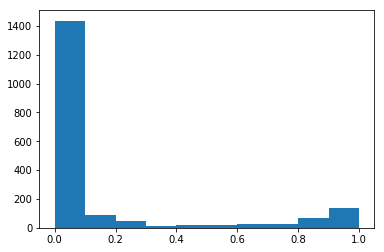

In [43]:
plt.hist(R_pred_frame_label)

In [44]:
torch.save(best_model, 'models/ts_labelmodel_best_tuning_downsampled.pth')

In [24]:
torch.save(best[2], 'models/ts_labelmodel_best_many_iterations.pth')

In [25]:
best_preds = best[2].predict_element_proba(Li_dev.to(device))

(array([5450.,  253.,   82.,   44.,   41.,   22.,   15.,   33.,   52.,
        1333.]),
 array([1.20012491e-05, 1.00009002e-01, 2.00006003e-01, 3.00003004e-01,
        4.00000005e-01, 4.99997006e-01, 5.99994007e-01, 6.99991008e-01,
        7.99988009e-01, 8.99985010e-01, 9.99982011e-01]),
 <a list of 10 Patch objects>)

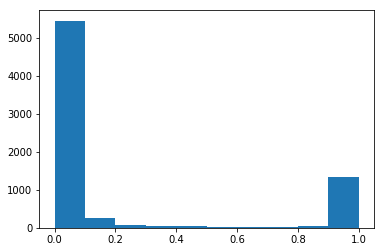

In [31]:
plt.hist(best_preds)

In [8]:
for seed, model in enumerate(temporal_models):
    model.flip_params()
    Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
    R_pred_frame_label = model.predict_element_proba(Li_dev.to(device)) #predict per element

    scores = [iterations, seed, model]
    for metric in ['accuracy', 'f1', 'recall', 'precision']:
        score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
        print(f"{metric.capitalize()}: {score:.3f}")

        scores.append(score)

    if best == None or scores[4] > best[4]:
        best = scores
    print()

Accuracy: 0.176
F1: 0.299
Recall: 1.000
Precision: 0.176

Accuracy: 0.005
F1: 0.054
Recall: 0.029
Precision: 0.493

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000

Accuracy: 0.176
F1: 0.299
Recall: 1.000
Precision: 0.176

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000

Accuracy: 0.176
F1: 0.299
Recall: 1.000
Precision: 0.176

Accuracy: 0.006
F1: 0.068
Recall: 0.036
Precision: 0.522

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000



In [9]:
print(best)

[2500, 0, DPLabelModel(), 0.17597269624573378, 0.2994192799070848, 1.0, 0.17606884305422757]


In [18]:
torch.save(best, 'models/ts_labelmodel_best_2500.pth')

In [10]:
R_pred_frame_label = best[2].predict_element_proba(Li_dev.to(device))

(array([4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 7.321e+03]),
 array([0.01257361, 0.11131625, 0.21005889, 0.30880153, 0.40754417,
        0.50628681, 0.60502945, 0.70377209, 0.80251473, 0.90125737,
        1.00000001]),
 <a list of 10 Patch objects>)

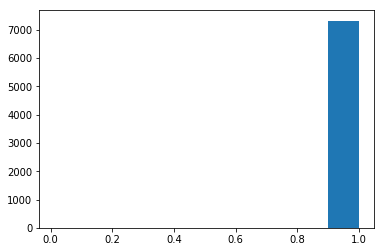

In [13]:
plt.hist(R_pred_frame_label)

In [18]:
preds = markov_model.predict_element_proba(Li_dev.to(device))

In [24]:
preds.shape

(7325,)

In [25]:
for metric in ['accuracy', 'f1', 'recall', 'precision']:
        score = metric_score(Y_dev.cpu(), np.round(preds), metric)
        print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.154
F1: 0.377
Recall: 0.876
Precision: 0.241


In [26]:
preds[:10]

array([0.99934805, 0.9738352 , 0.97474937, 0.93077044, 0.39215547,
       0.06551916, 0.03445013, 0.03749803, 0.28004386, 0.77988954])

In [28]:
R_pred_probs[:2]

array([[0.516888  , 0.516888  , 0.516888  , 0.516888  , 0.48311198],
       [0.53924423, 0.53924423, 0.53924423, 0.53924423, 0.46075577]],
      dtype=float32)

In [19]:
import matplotlib.pyplot as plt

(array([1638.,  276.,  236.,  135.,  346.,  731.,  854.,  962.,  534.,
        1613.]),
 array([3.50714667e-04, 1.00315638e-01, 2.00280562e-01, 3.00245486e-01,
        4.00210410e-01, 5.00175333e-01, 6.00140257e-01, 7.00105181e-01,
        8.00070105e-01, 9.00035028e-01, 9.99999952e-01]),
 <a list of 10 Patch objects>)

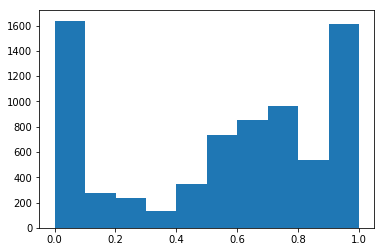

In [20]:
plt.hist(preds)

In [30]:
np.abs(R_pred_frame.detach().cpu().numpy())

array([[3.41327795e-05, 0.00000000e+00, 2.17160606e-03, ...,
        4.27972118e-05, 0.00000000e+00, 3.89957458e-01],
       [2.02080816e-01, 0.00000000e+00, 9.10843536e-03, ...,
        7.04662083e-03, 0.00000000e+00, 5.14468737e-03],
       [6.88242763e-02, 0.00000000e+00, 2.51607329e-01, ...,
        7.77709298e-04, 0.00000000e+00, 4.60530259e-02],
       ...,
       [1.05558075e-02, 0.00000000e+00, 3.71003598e-02, ...,
        7.99736604e-02, 0.00000000e+00, 2.26837486e-01],
       [9.67053056e-05, 0.00000000e+00, 5.52507641e-04, ...,
        4.20493714e-04, 0.00000000e+00, 2.81781822e-01],
       [1.14595937e-03, 0.00000000e+00, 4.02768841e-03, ...,
        7.53226504e-02, 0.00000000e+00, 2.13645339e-01]], dtype=float32)

(array([1523.,  724., 1270.,  681.,  958.,  720.,  430.,  350.,  427.,
         242.]),
 array([0.08463663, 0.17535003, 0.26606343, 0.35677683, 0.44749023,
        0.53820363, 0.62891703, 0.71963043, 0.81034383, 0.90105723,
        0.99177063]),
 <a list of 10 Patch objects>)

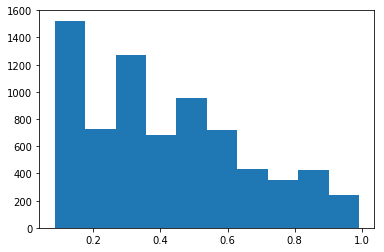

In [23]:
plt.hist(R_pred_probs.ravel())

In [21]:
R_pred_frame

tensor([[0.0000, 0.0000, 0.0022,  ..., 0.0000, 0.0000, 0.3900],
        [0.2021, 0.0000, 0.0091,  ..., 0.0070, 0.0000, 0.0051],
        [0.0688, 0.0000, 0.2516,  ..., 0.0008, 0.0000, 0.0461],
        ...,
        [0.0106, 0.0000, 0.0371,  ..., 0.0800, 0.0000, 0.2268],
        [0.0001, 0.0000, 0.0006,  ..., 0.0004, 0.0000, 0.2818],
        [0.0011, 0.0000, 0.0040,  ..., 0.0753, 0.0000, 0.2136]],
       device='cuda:0', grad_fn=<DivBackward1>)

In [22]:
R_pred_frame[0]

tensor([0.0000, 0.0000, 0.0022, 0.0209, 0.0000, 0.0000, 0.0000, 0.0455, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0005, 0.0000, 0.0218, 0.5169, 0.0000, 0.0000,
        0.0001, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0015,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3900],
       device='cuda:0', grad_fn=<SelectBackward>)

In [23]:
R_pred_frame[0].sum()

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [44]:
model.feasible_y

torch.Size([32, 5])

In [45]:
model.feasible_y

tensor([[-1, -1, -1, -1, -1],
        [-1,  1, -1, -1, -1],
        [ 1, -1, -1, -1, -1],
        [ 1,  1, -1, -1, -1],
        [-1, -1,  1, -1, -1],
        [-1,  1,  1, -1, -1],
        [ 1, -1,  1, -1, -1],
        [ 1,  1,  1, -1, -1],
        [-1, -1, -1,  1, -1],
        [-1,  1, -1,  1, -1],
        [ 1, -1, -1,  1, -1],
        [ 1,  1, -1,  1, -1],
        [-1, -1,  1,  1, -1],
        [-1,  1,  1,  1, -1],
        [ 1, -1,  1,  1, -1],
        [ 1,  1,  1,  1, -1],
        [-1, -1, -1, -1,  1],
        [-1,  1, -1, -1,  1],
        [ 1, -1, -1, -1,  1],
        [ 1,  1, -1, -1,  1],
        [-1, -1,  1, -1,  1],
        [-1,  1,  1, -1,  1],
        [ 1, -1,  1, -1,  1],
        [ 1,  1,  1, -1,  1],
        [-1, -1, -1,  1,  1],
        [-1,  1, -1,  1,  1],
        [ 1, -1, -1,  1,  1],
        [ 1,  1, -1,  1,  1],
        [-1, -1,  1,  1,  1],
        [-1,  1,  1,  1,  1],
        [ 1, -1,  1,  1,  1],
        [ 1,  1,  1,  1,  1]], device='cuda:0')

In [46]:
R_pred_frame.shape

torch.Size([1465, 32])

In [63]:
torch.mm(R_pred_frame, torch.where(
    model.feasible_y==-1,torch.tensor(0).to(device),model.feasible_y).float()
).detach().cpu().numpy().ravel()[:10]

array([0.99934804, 0.9738352 , 0.97474945, 0.93077046, 0.39215547,
       0.06551916, 0.03445013, 0.03749803, 0.28004387, 0.7798896 ],
      dtype=float32)

In [65]:
arr = model.feasible_y.detach().cpu().numpy()

In [68]:
arr[arr == -1] = 0

In [69]:
arr

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0],
       [1, 1, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 1, 0, 0, 1],
       [0, 0, 1, 0, 1],
       [0, 1, 1, 0, 1],
       [1, 0, 1, 0, 1],
       [1, 1, 1, 0, 1],
       [0, 0, 0, 1, 1],
       [0, 1, 0, 1, 1],
       [1, 0, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 1, 1, 1, 1],
       [1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [71]:
feasible_y_np = model.feasible_y.detach().cpu().numpy()
feasible_y_np[feasible_y_np == -1] = 0
np.matmul(
    R_pred_frame.detach().cpu().numpy(),
    feasible_y_np
).ravel()

array([0.99934805, 0.9738352 , 0.97474937, ..., 0.58535333, 0.58560057,
       0.89727236])

In [57]:
R_pred_frame[:2]

tensor([[0.0000, 0.0000, 0.0022, 0.0209, 0.0000, 0.0000, 0.0000, 0.0455, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0005, 0.0000, 0.0218, 0.5169, 0.0000, 0.0000,
         0.0001, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0015,
         0.0000, 0.0000, 0.0000, 0.0000, 0.3900],
        [0.2021, 0.0000, 0.0091, 0.0045, 0.0000, 0.0020, 0.0000, 0.0003, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0019, 0.0000, 0.0001, 0.0001, 0.4608, 0.0000,
         0.0258, 0.0084, 0.0000, 0.0069, 0.0000, 0.0000, 0.2397, 0.0000, 0.0121,
         0.0000, 0.0140, 0.0070, 0.0000, 0.0051]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [51]:
model.feasible_y

tensor([[-1, -1, -1, -1, -1],
        [-1,  1, -1, -1, -1],
        [ 1, -1, -1, -1, -1],
        [ 1,  1, -1, -1, -1],
        [-1, -1,  1, -1, -1],
        [-1,  1,  1, -1, -1],
        [ 1, -1,  1, -1, -1],
        [ 1,  1,  1, -1, -1],
        [-1, -1, -1,  1, -1],
        [-1,  1, -1,  1, -1],
        [ 1, -1, -1,  1, -1],
        [ 1,  1, -1,  1, -1],
        [-1, -1,  1,  1, -1],
        [-1,  1,  1,  1, -1],
        [ 1, -1,  1,  1, -1],
        [ 1,  1,  1,  1, -1],
        [-1, -1, -1, -1,  1],
        [-1,  1, -1, -1,  1],
        [ 1, -1, -1, -1,  1],
        [ 1,  1, -1, -1,  1],
        [-1, -1,  1, -1,  1],
        [-1,  1,  1, -1,  1],
        [ 1, -1,  1, -1,  1],
        [ 1,  1,  1, -1,  1],
        [-1, -1, -1,  1,  1],
        [-1,  1, -1,  1,  1],
        [ 1, -1, -1,  1,  1],
        [ 1,  1, -1,  1,  1],
        [-1, -1,  1,  1,  1],
        [-1,  1,  1,  1,  1],
        [ 1, -1,  1,  1,  1],
        [ 1,  1,  1,  1,  1]], device='cuda:0')

In [43]:
R_pred_frame

tensor([[0.0000, 0.0000, 0.0022,  ..., 0.0000, 0.0000, 0.3900],
        [0.2021, 0.0000, 0.0091,  ..., 0.0070, 0.0000, 0.0051],
        [0.0688, 0.0000, 0.2516,  ..., 0.0008, 0.0000, 0.0461],
        ...,
        [0.0106, 0.0000, 0.0371,  ..., 0.0800, 0.0000, 0.2268],
        [0.0001, 0.0000, 0.0006,  ..., 0.0004, 0.0000, 0.2818],
        [0.0011, 0.0000, 0.0040,  ..., 0.0753, 0.0000, 0.2136]],
       device='cuda:0', grad_fn=<DivBackward1>)

In [38]:
R_pred_frame.transpose(0, 1)

tensor([[0.0000, 0.2021, 0.0688,  ..., 0.0106, 0.0001, 0.0011],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0022, 0.0091, 0.2516,  ..., 0.0371, 0.0006, 0.0040],
        ...,
        [0.0000, 0.0070, 0.0008,  ..., 0.0800, 0.0004, 0.0753],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3900, 0.0051, 0.0461,  ..., 0.2268, 0.2818, 0.2136]],
       device='cuda:0', grad_fn=<TransposeBackward0>)

In [42]:
torch.mm(model.feasible_y.transpose(dim0=0, dim1=1).float(), R_pred_frame.transpose(0, 1)).transpose(0, 1)

tensor([[ 0.9987,  0.9477,  0.9495,  0.8615, -0.2157],
        [-0.8690, -0.9311, -0.9250, -0.4399,  0.5598],
        [ 0.6989, -0.4822, -0.8752, -0.6246,  0.0817],
        ...,
        [ 0.5028,  0.2961,  0.2270,  0.2729,  0.1078],
        [ 0.9919,  0.9809,  0.2497,  0.0447, -0.1122],
        [ 0.2565,  0.3115,  0.1707,  0.1712,  0.7945]],
       device='cuda:0', grad_fn=<TransposeBackward0>)

In [27]:
torch.dot(model.feasible_y.T, R_pred_frame[0])

RuntimeError: dot: Expected 1-D argument self, but got 2-D

In [16]:
R_pred_frame.shape

torch.Size([1465, 32])

In [19]:
R_pred_frame[0].abs().sum()

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [8]:
model.flip_params()

In [9]:
Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

#find sequence label config. with highest prob.
config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
R_pred_config = model.feasible_y[config_index]
R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

#for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
R_pred_probs = torch.FloatTensor(R_pred_config.shape)
for idx in range(R_pred_config.shape[0]):
    R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

R_pred_probs = R_pred_probs.numpy()
R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]

Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

#find sequence label config. with highest prob.
config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
R_pred_config = model.feasible_y[config_index]
R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

#for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
R_pred_probs = torch.FloatTensor(R_pred_config.shape)
for idx in range(R_pred_config.shape[0]):
    R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

R_pred_probs = R_pred_probs.numpy()
R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]
R_pred_frame_label = np.round(R_pred_probs.ravel())
R_pred_frame_label[R_pred_frame_label == 0.] = 2.

scores = [iterations, seed, model]
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), R_pred_frame_label, metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.511
F1: 0.304
Recall: 0.605
Precision: 0.203


In [11]:
best_model = best[2]

In [12]:
model = best_model
Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

#find sequence label config. with highest prob.
config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
R_pred_config = model.feasible_y[config_index]
R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

#for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
R_pred_probs = torch.FloatTensor(R_pred_config.shape)
for idx in range(R_pred_config.shape[0]):
    R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

R_pred_probs = R_pred_probs.numpy()
R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]

Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

#find sequence label config. with highest prob.
config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
R_pred_config = model.feasible_y[config_index]
R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

#for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
R_pred_probs = torch.FloatTensor(R_pred_config.shape)
for idx in range(R_pred_config.shape[0]):
    R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

R_pred_probs = R_pred_probs.numpy()
R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]
R_pred_frame_label = np.round(R_pred_probs.ravel())
R_pred_frame_label[R_pred_frame_label == 0.] = 2.

scores = [iterations]
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), R_pred_frame_label, metric)
    print(f"{metric.capitalize()}: {score:.3f}")

    scores.append(score)

Accuracy: 0.939
F1: 0.827
Recall: 0.836
Precision: 0.819


# Save/Load best model

In [45]:
model = best_model

In [24]:
torch.save(model, 'models/ts_labelmodel.pth')

In [3]:
model = torch.load('models/ts_labelmodel.pth').to(device)

In [32]:
model = torch.load('models/ts_labelmodel_best_many_iterations.pth').to(device)

In [34]:
model = torch.load('models/ts_labelmodel_best_tuning.pth').to(device)

In [5]:
model = torch.load('models/ts_labelmodel_best_tuning_downsampled.pth')

In [35]:
model.flip_params()

In [6]:
R_pred_frame_label = model.eval().predict_element_proba(
    MRI_data_temporal['Li_dev'].to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.125
F1: 0.861
Recall: 0.861
Precision: 0.861


In [7]:
R_pred_frame_label = model.eval().predict_element_proba(
    MRI_data_temporal['Li_test'].to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_test.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.143
F1: 0.768
Recall: 0.682
Precision: 0.878


# Make predictions for everything and save to disk

In [13]:
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
import pickle
import rekall
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.interval_list import IntervalList
from rekall.temporal_predicates import *
from metal.label_model.baselines import MajorityLabelVoter

## Load manually annotated data

In [14]:
with open('../../data/manually_annotated_shots.pkl', 'rb') as f:
    shots = VideoIntervalCollection(pickle.load(f))
with open('../../data/shot_detection_folds.pkl', 'rb') as f:
    shot_detection_folds = pickle.load(f)
clips = shots.dilate(1).coalesce().dilate(-1)
shot_boundaries = shots.map(
    lambda intrvl: (intrvl.start, intrvl.start, intrvl.payload)
).set_union(
    shots.map(lambda intrvl: (intrvl.end + 1, intrvl.end + 1, intrvl.payload))
).coalesce()
boundary_frames = {
    video_id: [
        intrvl.start
        for intrvl in shot_boundaries.get_intervallist(video_id).get_intervals()
    ]
    for video_id in shot_boundaries.get_allintervals()
}
video_ids = sorted(list(clips.get_allintervals().keys()))
frames_per_video = {
    video_id: sorted([
        f
        for interval in clips.get_intervallist(video_id).get_intervals()
        for f in range(interval.start, interval.end + 2)
    ])
    for video_id in video_ids
}
ground_truth = {
    video_id: [
        1 if f in boundary_frames[video_id] else 2
        for f in frames_per_video[video_id]
    ] 
    for video_id in video_ids
}

100%|██████████| 28/28 [00:00<00:00, 44250.38it/s]


## Load label matrix with all frames in it

In [19]:
with open('../../data/shot_detection_weak_labels/all_labels.pkl', 'rb') as f:
    weak_labels_all_movies = pickle.load(f)

## Load videos and number of frames per video

In [20]:
with open('../../data/frame_counts.pkl', 'rb') as f:
    frame_counts = pickle.load(f)
video_ids_all = sorted(list(frame_counts.keys()))
video_ids_train = sorted(list(set(video_ids_all).difference(set(video_ids))))

## Construct windows for each video

In [17]:
# First, construct windows of 16 frames for each video
windows = VideoIntervalCollection({
    video_id: [
        (f, f + 16, video_id)
        for f in range(0, frame_counts[video_id] - 16, 16)
    ]
    for video_id in video_ids_all
})

## Get ground truth labels for all windows

In [41]:
# Next, intersect the windows with ground truth and get ground truth labels for the windows
windows_intersecting_ground_truth = windows.filter_against(
    clips,
    predicate=overlaps()
).map(lambda intrvl: (intrvl.start, intrvl.end, 2))
windows_with_shot_boundaries = windows_intersecting_ground_truth.filter_against(
    shot_boundaries,
    predicate = lambda window, shot_boundary:
        shot_boundary.start >= window.start and shot_boundary.start < window.end
).map(
    lambda intrvl: (intrvl.start, intrvl.end, 1)
)
windows_with_labels = windows_with_shot_boundaries.set_union(
    windows_intersecting_ground_truth
).coalesce(
    predicate = equal(),
    payload_merge_op = lambda p1, p2: min(p1, p2)
)

## Get weak labels for all windows

In [21]:
# Label windows with the weak labels in our labeling functions
def label_window(per_frame_weak_labels):
    if 1 in per_frame_weak_labels:
        return 1
    if len([l for l in per_frame_weak_labels if l == 2]) >= len(per_frame_weak_labels) / 2:
        return 2
    return 0

windows_with_weak_labels = windows.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all_movies
        ]
    )
)

# L matrix

In [ ]:
L_everything_windows = csr_matrix([
    intrvl.payload
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]).todense()

In [41]:
with open('../../data/shot_detection_weak_labels/L_everything_windows_downsampled.npy', 'wb') as f:
    np.save(f, L_everything_windows)

In [22]:
with open('../../data/shot_detection_weak_labels/L_everything_windows_downsampled.npy', 'rb') as f:
    L_everything_windows = np.load(f)

# Convert L matrix to timeseries

In [23]:
T = 5
m_per_task = L_everything_windows.shape[1]

In [24]:
L_unlabelled = torch.FloatTensor(L_everything_windows[:L_everything_windows.shape[0] -
                                                      (L_everything_windows.shape[0] % T)]).to(device)

In [25]:
m_per_task_unlabelled = L_unlabelled.size(1)
n_frames_unlabelled = L_unlabelled.size(0)
n_patients_unlabelled = n_frames_unlabelled//T

In [26]:
L_unlabelled_ts = torch.LongTensor(
    L_unlabelled.view(n_patients_unlabelled, (m_per_task*T)).cpu().numpy())

# Predict everything

In [49]:
L_unlabelled_ts.shape[0]

1235081

In [68]:
model.flip_params()

In [50]:
predictions_val = model.eval().predict_element_proba(MRI_data_temporal['Li_dev'])

(array([1436.,   92.,   49.,   14.,   21.,   19.,   29.,   23.,   65.,
         137.]),
 array([7.98336298e-08, 9.99848064e-02, 1.99969533e-01, 2.99954259e-01,
        3.99938986e-01, 4.99923713e-01, 5.99908439e-01, 6.99893166e-01,
        7.99877892e-01, 8.99862619e-01, 9.99847345e-01]),
 <a list of 10 Patch objects>)

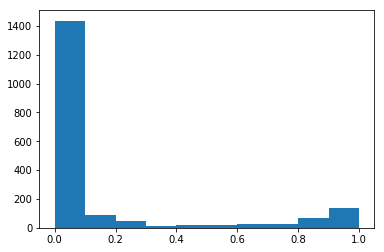

In [51]:
plt.hist(predictions_val)

In [52]:
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu().where(Y_dev.cpu() == torch.tensor(1.), torch.tensor(0.)),
                         np.round(predictions_val), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.960
F1: 0.861
Recall: 0.861
Precision: 0.861


In [53]:
predictions_everything = []
for i in range(0, L_unlabelled_ts.shape[0], 100000):
    print(i)
    start = i
    end = i + 100000
    labels = L_unlabelled_ts[start:end] if end < L_unlabelled_ts.shape[0] else L_unlabelled_ts[start:]
    predictions_for_labels = model.eval().predict_element_proba(labels.to(device))
    predictions_everything.append(predictions_for_labels)
    del predictions_for_labels
    torch.cuda.empty_cache()

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000


In [54]:
np.concatenate(predictions_everything).shape

(6175405,)

In [55]:
R_pred_probs_per_frame = np.concatenate(predictions_everything)

In [14]:
# R_pred_frame = predictions_everything_together

# #find sequence label config. with highest prob.
# config_index = np.argmax(R_pred_frame, axis=1)
# R_pred_config = model.feasible_y[config_index].detach().cpu()
# R_pred_max = torch.FloatTensor(np.max(R_pred_frame.numpy(), axis=1))

# #for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
# R_pred_probs = torch.FloatTensor(R_pred_config.shape)
# for idx in range(R_pred_config.shape[0]):
#     R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:]).float()*R_pred_max[idx]

# R_pred_probs = R_pred_probs.numpy()
# R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]
# R_pred_frame_label = np.round(R_pred_probs.ravel())
# R_pred_frame_label[R_pred_frame_label == 0.] = 2.

# R_pred_probs_per_frame = R_pred_probs.ravel()

(array([3974824.,  895914.,  365832.,  102541.,  102136.,  119002.,
         114341.,  184300.,  126978.,  189537.]),
 array([5.18732044e-08, 9.99846214e-02, 1.99969191e-01, 2.99953760e-01,
        3.99938330e-01, 4.99922899e-01, 5.99907469e-01, 6.99892038e-01,
        7.99876608e-01, 8.99861177e-01, 9.99845747e-01]),
 <a list of 10 Patch objects>)

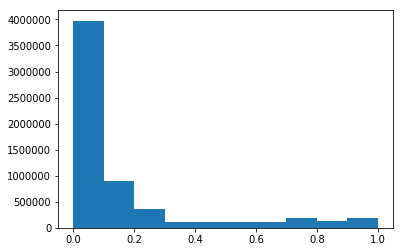

In [56]:
plt.hist(R_pred_probs_per_frame)

In [57]:
L_unlabelled_ts[-10:]

tensor([[2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0,
         0],
        [1, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 1, 0, 2, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0,
         0]])

# Save predictions to disk

In [59]:
window_nums = [
    (video_id, intrvl.start, intrvl.end)
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]

In [61]:
predictions_to_save_windows = [
    (window_info, np.array([prediction, 1. - prediction]))
    for window_info, prediction in zip(window_nums, R_pred_probs_per_frame)
]

In [62]:
# Because we needed to cut the predictions to a multiple of T
last_preds = []
for window_info in window_nums[len(predictions_to_save_windows):]:
    last_preds.append((window_info, np.array([0., 1.])))

In [63]:
last_preds

[]

In [ ]:
predictions_to_save_windows += last_preds

In [64]:
preds_np_windows = np.array(predictions_to_save_windows)

In [65]:
# save predictions to disk
with open('../../data/shot_detection_weak_labels/ts_weak_labels_all_windows_tuned_downsampled.npy', 'wb') as f:
    np.save(f, preds_np_windows)

# Distribution compared to Metal LabelModel

In [66]:
import matplotlib.pyplot as plt

In [59]:
preds_np_windows[:10]

array([[(1, 0, 16), array([0., 1.])],
       [(1, 8, 24), array([0., 1.])],
       [(1, 16, 32), array([0., 1.])],
       [(1, 24, 40), array([0., 1.])],
       [(1, 32, 48), array([0., 1.])],
       [(1, 40, 56), array([0.01515144, 0.98484856])],
       [(1, 48, 64), array([0.98484856, 0.01515144])],
       [(1, 56, 72), array([0.98484856, 0.01515144])],
       [(1, 64, 80), array([0.01515144, 0.98484856])],
       [(1, 72, 88), array([0.01515144, 0.98484856])]], dtype=object)

In [64]:
preds_np_windows.shape

(12350523, 2)

In [62]:
with open('../../data/shot_detection_weak_labels/noisy_labels_all_windows.npy', 'rb') as f:
    preds_np_windows_metal = np.load(f)

In [63]:
preds_np_windows_metal[:10]

array([[(1, 0, 16), array([0.0032828, 0.9967172])],
       [(1, 8, 24), array([0.0032828, 0.9967172])],
       [(1, 16, 32), array([0.0032828, 0.9967172])],
       [(1, 24, 40), array([0.0032828, 0.9967172])],
       [(1, 32, 48), array([0.0032828, 0.9967172])],
       [(1, 40, 56), array([0.24933879, 0.75066121])],
       [(1, 48, 64), array([0.98051349, 0.01948651])],
       [(1, 56, 72), array([0.36412127, 0.63587873])],
       [(1, 64, 80), array([0.0032828, 0.9967172])],
       [(1, 72, 88), array([0.0032828, 0.9967172])]], dtype=object)

In [65]:
preds_np_windows_metal.shape

(12350523, 2)

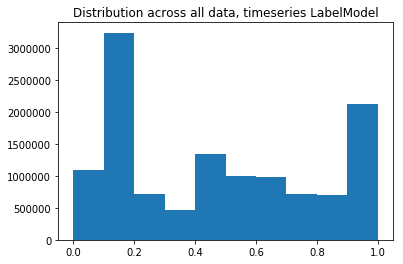

In [75]:
fig, ax = plt.subplots()
ax.set_title('Distribution across all data, timeseries LabelModel')
ax.hist([
    i[1][0]
    for i in preds_np_windows
])
plt.show()

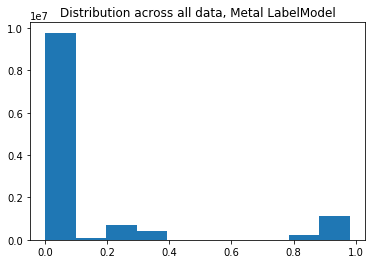

In [76]:
fig, ax = plt.subplots()
ax.set_title('Distribution across all data, Metal LabelModel')
ax.hist([
    i[1][0]
    for i in preds_np_windows_metal
])
plt.show()

In [79]:
with open('../../data/shot_detection_weak_labels/majority_vote_labels_all_windows.npy', 'rb') as f:
    preds_np_windows_mv = np.load(f)

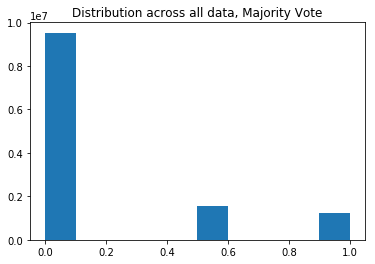

In [81]:
fig, ax = plt.subplots()
ax.set_title('Distribution across all data, Majority Vote')
ax.hist([
    i[1][0]
    for i in preds_np_windows_mv
])
plt.show()

# Old stuff (bad class balance, wrong R_dev)

In [97]:
%%time 
max_seed = 10
temporal_models = [None,]*max_seed
for seed in range(max_seed):
    markov_model = DPLabelModel(m=m_per_task*T, 
                                T=T,
                                edges=[(i,i+m_per_task) for i in range((T-1)*m_per_task)],
                                coverage_sets=[[t,] for t in range(T) for _ in range(m_per_task)],
                                mu_sharing=[[t*m_per_task+i for t in range(T)] for i in range(m_per_task)],
                                phi_sharing=[[(t*m_per_task+i, (t+1)*m_per_task+i) for t in range(T-1)] for i in range(m_per_task)],
                                device=device,
                                # class_balance=MRI_data_temporal['class_balance'],
                                seed=seed)
    optimize(markov_model, L_hat=MRI_data_temporal['Li_train'], num_iter=10, lr=1e-5, momentum=0.8, clamp=True, 
             verbose=False, seed=seed)
    temporal_models[seed] = markov_model

CPU times: user 41.8 s, sys: 1.6 s, total: 43.4 s
Wall time: 43.4 s


In [98]:
for seed, model in enumerate(temporal_models):
    Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
    R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

    #find sequence label config. with highest prob.
    config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
    R_pred_config = model.feasible_y[config_index]
    R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

    #for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
    R_pred_probs = torch.FloatTensor(R_pred_config.shape)
    for idx in range(R_pred_config.shape[0]):
        R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

    R_pred_probs = R_pred_probs.numpy()
    R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]

    Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
    R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

    #find sequence label config. with highest prob.
    config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
    R_pred_config = model.feasible_y[config_index]
    R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

    #for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
    R_pred_probs = torch.FloatTensor(R_pred_config.shape)
    for idx in range(R_pred_config.shape[0]):
        R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

    R_pred_probs = R_pred_probs.numpy()
    R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]
    R_pred_frame_label = np.round(R_pred_probs.ravel())
    R_pred_frame_label[R_pred_frame_label == 0.] = 2.

    for metric in ['accuracy', 'f1', 'recall', 'precision']:
        score = metric_score(Y_dev.cpu(), R_pred_frame_label, metric)
        print(f"{metric.capitalize()}: {score:.3f}")

(7325,)
Accuracy: 0.357
F1: 0.090
Recall: 0.182
Precision: 0.060
(7325,)
Accuracy: 0.369
F1: 0.184
Recall: 0.404
Precision: 0.119
(7325,)
Accuracy: 0.523
F1: 0.218
Recall: 0.377
Precision: 0.153
(7325,)
Accuracy: 0.388
F1: 0.225
Recall: 0.506
Precision: 0.145
(7325,)
Accuracy: 0.375
F1: 0.234
Recall: 0.542
Precision: 0.149
(7325,)
Accuracy: 0.668
F1: 0.344
Recall: 0.494
Precision: 0.263
(7325,)
Accuracy: 0.580
F1: 0.086
Recall: 0.112
Precision: 0.069
(7325,)
Accuracy: 0.509
F1: 0.154
Recall: 0.254
Precision: 0.111
(7325,)
Accuracy: 0.277
F1: 0.024
Recall: 0.050
Precision: 0.015
(7325,)
Accuracy: 0.544
F1: 0.279
Recall: 0.500
Precision: 0.193


In [18]:
# num_iter=1 (20s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.207  F1=0.294  precision=0.175 recall=0.931 
seed=1  accuracy=0.208  F1=0.270  precision=0.161 recall=0.823 
seed=2  accuracy=0.730  F1=0.168  precision=0.185 recall=0.154 
seed=3  accuracy=0.182  F1=0.300  precision=0.177 recall=0.988 
seed=4  accuracy=0.196  F1=0.283  precision=0.168 recall=0.892 
seed=5  accuracy=0.674  F1=0.143  precision=0.134 recall=0.154 
seed=6  accuracy=0.812  F1=0.000  precision=0.000 recall=0.000 
seed=7  accuracy=0.499  F1=0.193  precision=0.135 recall=0.338 
seed=8  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=9  accuracy=0.639  F1=0.470  precision=0.318 recall=0.904 


In [20]:
# num_iter=10 (40s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.616  F1=0.228  precision=0.177 recall=0.319 
seed=3  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=4  accuracy=0.174  F1=0.293  precision=0.173 recall=0.965 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.739  F1=0.073  precision=0.098 recall=0.058 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 


In [22]:
# num_iter=50 (2 min 25s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=3  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=4  accuracy=0.661  F1=0.347  precision=0.263 recall=0.508 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.386  F1=0.334  precision=0.207 recall=0.865 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 


In [24]:
# num_iter=100 (4 min 28s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=3  accuracy=0.621  F1=0.224  precision=0.176 recall=0.308 
seed=4  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 


In [26]:
# num_iter=500 (22 min 2s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=1  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=2  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=3  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=4  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=5  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=6  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=7  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=8  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=9  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 


# Notes on runs

```
1 iteration:
seed=0  accuracy=0.207  F1=0.294  precision=0.175 recall=0.931 
seed=1  accuracy=0.208  F1=0.270  precision=0.161 recall=0.823 
seed=2  accuracy=0.730  F1=0.168  precision=0.185 recall=0.154 
seed=3  accuracy=0.182  F1=0.300  precision=0.177 recall=0.988 
seed=4  accuracy=0.196  F1=0.283  precision=0.168 recall=0.892 
seed=5  accuracy=0.674  F1=0.143  precision=0.134 recall=0.154 
seed=6  accuracy=0.812  F1=0.000  precision=0.000 recall=0.000 
seed=7  accuracy=0.499  F1=0.193  precision=0.135 recall=0.338 
seed=8  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=9  accuracy=0.639  F1=0.470  precision=0.318 recall=0.904

10 iterations:
seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.616  F1=0.228  precision=0.177 recall=0.319 
seed=3  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=4  accuracy=0.174  F1=0.293  precision=0.173 recall=0.965 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.739  F1=0.073  precision=0.098 recall=0.058 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000

50 iterations:
seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=3  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=4  accuracy=0.661  F1=0.347  precision=0.263 recall=0.508 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.386  F1=0.334  precision=0.207 recall=0.865 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 

100 iterations:
seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=3  accuracy=0.621  F1=0.224  precision=0.176 recall=0.308 
seed=4  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 

500 iterations:
seed=0  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=1  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=2  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=3  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=4  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=5  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=6  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=7  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=8  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=9  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
```